# Autocorrelation-based boundary detection

In [17]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.graph import Graph
from esda import Moran_Local, Geary_Local
from sklearn.decomposition import PCA

Load all buildings represented as points.

In [ ]:
complete = gpd.read_parquet("/data/uscuni-boundaries/classification/v202509/").reset_index(drop=True)

Map ids to level 3.

In [3]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
complete["level_3"] = complete.final_without_noise.map(final_clusters[3])

Make a grid

In [4]:
grid_size = 50_000

In [5]:
bds = complete.total_bounds
bds

array([4031349.95272902, 2597498.33419905, 5378847.07173358,
       3799811.41843362])

In [6]:
x = np.arange(bds[0], bds[2], grid_size)
y = np.arange(bds[1], bds[3], grid_size)

In [7]:
xs, ys = np.meshgrid(x, y)

In [8]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(
    grid_size / 2, cap_style="square"
)

Join grid label to points

In [9]:
grid = grid.to_frame("geometry")
joined = complete.sjoin(grid, predicate="within")

Group by grid label and get counts by class.

In [10]:
counts = joined.groupby("index_right").final_without_noise.value_counts().unstack().fillna(0)
counts = counts.div(counts.sum(axis=1), axis=0)
counts

final_without_noise,1,2,3,4,5,6,7,8,9,10,...,101,102,103,104,105,106,107,108,109,110
index_right,,,,,,,,,,,,,,,,,,,,,
10,0.000769,0.000000,0.000000,0.047290,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.066513,0.0,0.000000,0.0
11,0.001865,0.000000,0.007459,0.011893,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.010533,0.007207,0.015522,0.0,0.000000,0.0
12,0.008204,0.010997,0.026254,0.005845,0.002007,0.007723,0.0,0.0,0.0,0.000000,...,0.005011,0.0,0.0002,0.0,0.003685,0.002993,0.009366,0.0,0.000000,0.0
13,0.001107,0.000000,0.000761,0.003321,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.006745,0.000000,0.003874,0.0,0.003321,0.0
32,0.000906,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.077271,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0.020026,0.000000,0.003038,0.003073,0.000000,0.000000,0.0,0.0,0.0,0.003798,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


Join

In [11]:
grid_data = pd.concat([grid, counts], axis=1)

Drop cells outside of the area

In [12]:
grid_data = grid_data.dropna().reset_index()

Build contiguity graph and use it ot compute Local Moran's I. 

In [13]:
contig = Graph.build_contiguity(grid_data, rook=False).transform('r')

lisa = Moran_Local(grid_data[3].fillna(0), contig)

Get bounddaries for each cluster type and each p value

In [14]:
boundaries = []
for i in range(1, 9):
    for p in [0.1, 0.05, 0.01]:
        lisa = Moran_Local(grid_data[i].fillna(0), contig)
        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "High-High")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "Low-Low")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

Plot the boundaries

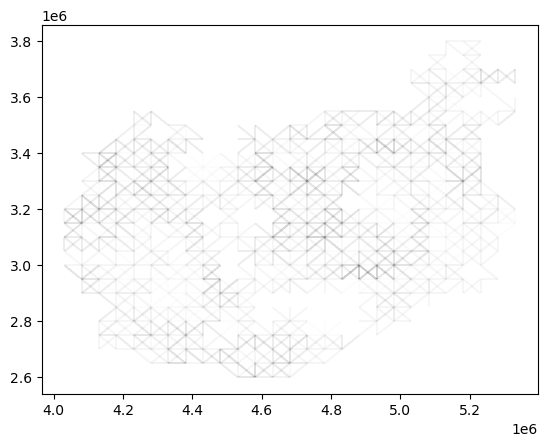

In [16]:
f, ax = plt.subplots()

for bound in boundaries:
    bound.plot(grid_data, ax=ax, nodes=False, edge_kws=dict(alpha=.01))

Using PCA

In [18]:
pca = PCA(3).fit(grid_data.iloc[:, 2:].values)

Check variance ration

In [19]:
pca.explained_variance_ratio_

array([0.23489325, 0.10328756, 0.07577708])

Get PCAs

In [ ]:
comps = pca.transform(grid_data.iloc[:, 2:].values)

Get LISA of PCA of proportions

In [ ]:
lisa_comp = Moran_Local(comps[:, 2], contig)

In [ ]:
lisa_comp.explore(grid_data)